# Utilizing Machine Learning and Image Similarity Metrics for Discriminating Healthy and Anomalous Brain Images: Insights from Reconstruction Algorithms for Classification Tasks

## Preprocessing images

### Includes

In [35]:
%matplotlib inline
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater
import pydicom

### Skull Stripping Function

Full credit on this skull stripping functionality to: Richard Barnes. (2018). Using Otsu's method for skull-brain segmentation (v1.0.1). Zenodo. https://doi.org/10.5281/zenodo.6042312

In [ ]:
def skull_strip(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    colormask = np.zeros(img.shape, dtype = np.uint8)
    colormask[thresh!=0] = np.array((0,0,255))
    blended = cv2.addWeighted(img, 0.7, colormask, 0.1, 0)

    ret, markers = cv2.connectedComponents(thresh)
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]
    largest_component = np.argmax(marker_area)+1
    brain_mask = markers == largest_component
    brain_out = img.copy()
    brain_out[brain_mask == False] = (0,0,0)

    brain_out_resized = cv2.resize(brain_out, (256, 256))

    return brain_out_resized

### Image Blurring Function

I want to apply a certain amount of blur to a brain image, since I will be using images of healthy brains with a blur filter as training data.

In [77]:
def apply_gaussian_blur(image, radius, target_size=(256, 256)):
    """
    Apply Gaussian blur to the input image.

    Parameters
        image (str or PIL.Image.Image): Image file path or PIL Image object.
        radius (float): Radius for Gaussian blur.
        target_size (tuple): Target size for resizing the image.

    Returns
        PIL.Image.Image: Blurred image.
    """
    if isinstance(image, str):
        img = Image.open(image)
    elif isinstance(image, Image.Image):
        img = image
    else:
        raise ValueError("Input must be a file path (str) or PIL Image object.")
    
    img = img.resize(target_size)
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius))
    return blurred_img

## Processing data

### Function to obtain Numpy data from a folder of images

In order to train the model, I need to first obtain the ready-to-use data from a folder of images. These images are the brain images after having passed through a skull-stripping process. 

This function will go through each of the images in the folder, convert the image into a numpy array and append each image to a list. This list will then be converted into a numpy array. Given a folder of images as input, the output of the function will be an array of $n \times 256 \times 256 \times 3$. Here, $n$ is the number of elements (images) in the folder, 256 by 256 represents the size of the image and 3 for RGB.

In [16]:
def create_array_from_folder(folder_path):
    image_size = (256, 256)
    image_files = [file for file in os.listdir(folder_path)]

    image_arrays = []

    for file in image_files:
        image_path = os.path.join(folder_path, file)
        img = Image.open(image_path)
        img = img.resize(image_size)
        img_array = np.array(img)
        image_arrays.append(img_array)
        
    return_array = np.array(image_arrays)
    return return_array

Implementing the function, will provide us with all the numpy data to use for training and testing the model

### Obtaining ready-to-use data

In [15]:
X = create_array_from_folder("Blurred150")
Y = create_array_from_folder("ProcessedImages")
print(X.shape, Y.shape)

(53, 256, 256, 3) (53, 256, 256, 3)


Separating the data into training and test data split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In order to being able to use this data with tensorflow, we have to convert it into a tensowrflow's tensor data type. Here we simply use the 'convert_to_tensor' method from tensorflow. 

In [12]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
Y_train = tf.convert_to_tensor(Y_train)
Y_test = tf.convert_to_tensor(Y_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X.shape)

(37, 256, 256, 3)
(16, 256, 256, 3)
(37, 256, 256, 3)
(16, 256, 256, 3)
(53, 256, 256, 3)


## Training Reconstruction Model

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (9, 9), activation="relu", padding="same", input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (1, 1), activation="relu", padding="same"),
    tf.keras.layers.Conv2D(3, (5, 5), activation="linear", padding="same")
])

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_test, Y_test))

loss = model.evaluate(X_test, Y_test)
print("Test loss:", loss)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 2504.7683 - val_loss: 589.2913
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 334.5280 - val_loss: 325.4449
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 307.2513 - val_loss: 183.7386
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 177.9505 - val_loss: 201.8525
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 198.4051 - val_loss: 169.1595
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 164.3497 - val_loss: 163.2062
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 164.7137 - val_loss: 161.9688
Epoch 8/10
3/3 [==============================] - 5s 2s/step - loss: 156.8841 - val_loss: 142.7665
Epoch 9/10
3/3 [==============================] - 5s 2s/step - loss: 139.4757 - val_loss: 138.2435
Epoch 10/10
1/1 [==============================] - 0s 340ms/step - loss: 125.0237
Test loss: 125.02373504638

### Function to Generate an Image

In [90]:
def generate_img(blurred_img):
    image_size = (256,256)
    blurred_img = blurred_img.resize(image_size)  # Corrected variable name
    blurred_img_array = np.array(blurred_img) / 255.0

    input_img = np.expand_dims(blurred_img_array, axis=0)
    refined_img = model.predict(input_img)

    refined_img = refined_img[0] * 255.0
    refined_img_array = np.clip(refined_img, 0, 255)  # Corrected variable name
    predicted_img = Image.fromarray(np.uint8(refined_img_array))
    return predicted_img

## Visualizing Reconstruction of Images: Using predict() with a training image

1/1 [==============================] - 0s 86ms/step
Case: Healthy Brain, included in training data
Original Image, Blurred Image, Refined Image:


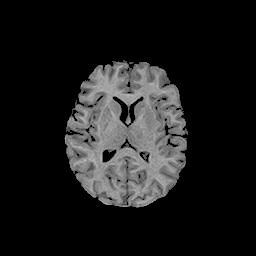

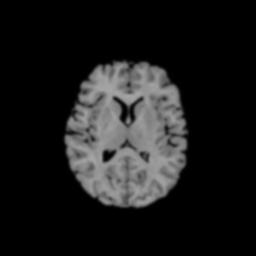

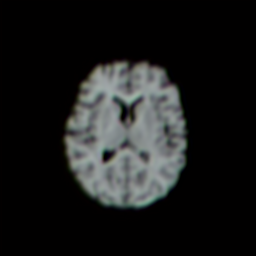

In [95]:
blurred_img_healthy = Image.open("Blurred125/blurred125radius17.jpg")
original_img_healthy = Image.open("ProcessedImages/stripped17.jpg")
refined_img_healthy = generate_img(blurred_img_healthy)

print("Case: Healthy Brain, included in training data")
print("Original Image, Blurred Image, Refined Image:")
display(original_img_healthy, blurred_img_healthy, refined_img_healthy)

## Visualizing Reconstruction of Images: Using predict() with an image of a brain with physiological anomalies

### Original image of a brain with a tumor

1/1 [==============================] - 0s 85ms/step
Case: Brain with an anomaly, not included in training data
Original Image, Blurred Image, Refined Image:


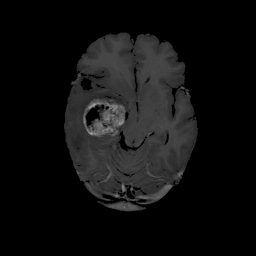

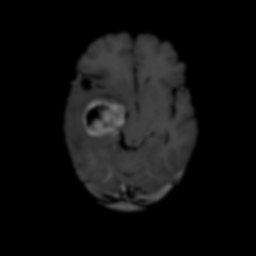

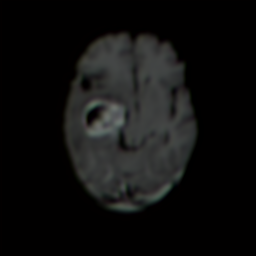

In [94]:
img = skull_strip("tumorbrain.png")
original_img_tumor = Image.fromarray(np.uint8(img))
blurred_img_tumor = apply_gaussian_blur(skull_stripped, radius = 1.50)
refined_img_tumor = generate_img(blurred_img_tumor)

print("Case: Brain with an anomaly, not included in training data")
print("Original Image, Blurred Image, Refined Image:")
display(original_img_tumor, blurred_img_tumor, refined_img_tumor)

# Obtaining Possible Metric for Anomaly Detection

So far, the refinement doesn't seem to be giving good results with the current small dataset and the current architecture

However, I am interested if I can obtain some metric given by this "reconstruction" of the image that can help in identifying anomalies in the brain.

Each image can be thought of as an $n \times n$ matrix $\textbf{A}$. After this image is blurred, we obtain a new matrix $\textbf{B}$. In an ideal scenario of perfect reconstruction, a transformation $f(\textbf{B})$, should yield a matrix that exactly matches the original image:
$$
f(\textbf{B}) = A
$$

Then, the matrix subtraction of these two matrices, should be the $n \times n$ $\textbf{0}$ matrix:
$$
|\textbf{A} - f(\textbf{B})| = 0
$$

However, achieving perfect reconstruction is often unattainable due to various factors such as noise, resolution limitations, and the inherent complexity of the scene. Consequently, the reconstructed matrix $f(\textbf{B})$ is typically only "similar" to the original matrix $\textbf{A}$
In order to quantify the difference between $\textbf{A}$ and $f(\textbf{B})$ we use a similarity metric.
We can use a variety of metrics to measure this difference, such as the Root-Mean-Square Error (RMSE), Peak signal-to-noise ratio (PSNR), Structural Similarity Index (SSI) and Pearson's r. Let's denote this similarity measure operator between the reconstructed image $f(\textbf{B})$ and the original image $\textbf{A}$ as  $S(f(\textbf{B}), \textbf{A})$.

We can take advantage of the fact that the reconstruction model is only trained with images of healthy brains. We can thus hypothesize that the model will be best at reconstructing images of healthy brains rather than those of unhealthy brains. Suppose that the operator $S(f(\textbf{B}), \textbf{A})$ returns a real number. Then for two cases, one for a healthy brain, $S(f(\textbf{B})_{healthy}, \textbf{A}_{healthy})$, and another for a brain with a physiological anomaly, $S(f(\textbf{B})_{anomaly}, \textbf{A}_{anomaly})$, we can hypothesize that
$$S(f(\textbf{B})_{healthy}, \textbf{A}_{healthy}) > S(f(\textbf{B})_{anomaly}, \textbf{A}_{anomaly})$$

### Preprocessing: Obtaining Numpy Matrices

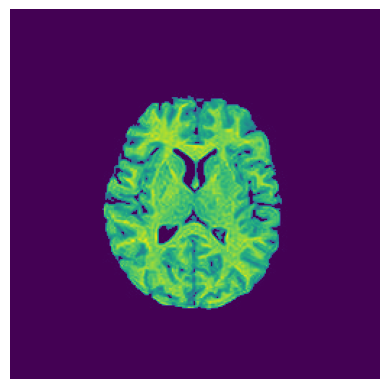

In [151]:
def obtain_matrices(original, reconstructed):
    original = np.array(original)
    reconstructed = np.array(reconstructed)
    original = original[:,:,0]
    reconstructed = reconstructed[:,:,2]
    return original, reconstructed

def visualize_matrix(matrix):
    plt.imshow(matrix)
    plt.axis('off')
    plt.show()


original_healthy, reconstructed_healthy = obtain_matrices(original_img_healthy, refined_img_healthy)
original_tumor, reconstructed_tumor = obtain_matrices(original_img_tumor, refined_img_tumor)
visualize_matrix(original_healthy)

In [152]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [153]:
def MSE(A,B):
    squared_difference = (A - B) ** 2
    mse = np.mean(squared_difference)
    return mse

def RMSE(A,B):
    mse = MSE(A,B)
    rmse = np.sqrt(mse)
    return rmse


In [168]:
print("------------------RMSE----------------------")

rmse_healthy = RMSE(reconstructed_healthy, original_healthy)
rmse_tumor = RMSE(reconstructed_tumor, original_tumor)
print("Healthy Case RMSE: ", rmse_tumor)
print("Tumor Case RMSE: ", rmse_healthy)

print("------------------SSI---------------------")

ssi_healthy = ssim(reconstructed_healthy, original_healthy, win_size = 255, multichannel = False)
ssi_tumor = ssim(reconstructed_tumor, original_tumor, win_size = 255, multichannel = False)

print("Healthy Case Structural Similarity Index:", ssi_healthy)
print("Tumor Case Structural Similarity Index:", ssi_tumor)

print("------------------Cos_Sim-------------------")

cos_sim_healthy = cosine_similarity(reconstructed_healthy, original_healthy)[0][0]
print("Original Case Cosine Similarity:", cos_sim_healthy)
cos_sim_tumor = cosine_similarity(reconstructed_tumor, original_tumor)[0][0]
print("Tumor Case Cosine Similarity:", cos_sim_tumor)

print("-----------------Pearson R-----------------------")

pearson_r_healthy, _ = pearsonr(reconstructed_healthy.flatten(), original_healthy.flatten())
pearson_r_tumor, _ = pearsonr(reconstructed_tumor.flatten(), original_tumor.flatten())

print("Healthy Case Pearson correlation coefficient:", pearson_r_healthy)
print("Tumor Case Pearson correlation coefficient:", pearson_r_tumor)

------------------RMSE----------------------
Healthy Case RMSE:  3.6216457238420543
Tumor Case RMSE:  4.372851034722656
------------------SSI---------------------
Healthy Case Structural Similarity Index: 0.974634588502188
Tumor Case Structural Similarity Index: 0.9703233719251269
------------------Cos_Sim-------------------
Original Case Cosine Similarity: 0.0
Tumor Case Cosine Similarity: 0.0
-----------------Pearson R-----------------------
Healthy Case Pearson correlation coefficient: 0.9749840782369587
Tumor Case Pearson correlation coefficient: 0.9735319071301703
